In [34]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d


C:\Users\domin\AppData\Local\Temp\ipykernel_77012\2285119196.py:9: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [35]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")

In [36]:
train['date'] = pd.to_datetime(train['date']).dt.to_period('D')
#train = train.set_index('date') 



In [37]:
train.head(18)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   id        136950 non-null  int64    
 1   date      136950 non-null  period[D]
 2   country   136950 non-null  object   
 3   store     136950 non-null  object   
 4   product   136950 non-null  object   
 5   num_sold  136950 non-null  int64    
dtypes: int64(2), object(3), period[D](1)
memory usage: 6.3+ MB


In [39]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Enc_col = ['country', 'store', 'product' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: country
  Wartość zakodowana: 0 -> Wartość początkowa: Argentina
  Wartość zakodowana: 1 -> Wartość początkowa: Canada
  Wartość zakodowana: 2 -> Wartość początkowa: Estonia
  Wartość zakodowana: 3 -> Wartość początkowa: Japan
  Wartość zakodowana: 4 -> Wartość początkowa: Spain
Kolumna: store
  Wartość zakodowana: 0 -> Wartość początkowa: Kagglazon
  Wartość zakodowana: 1 -> Wartość początkowa: Kaggle Learn
  Wartość zakodowana: 2 -> Wartość początkowa: Kaggle Store
Kolumna: product
  Wartość zakodowana: 0 -> Wartość początkowa: Using LLMs to Improve Your Coding
  Wartość zakodowana: 1 -> Wartość początkowa: Using LLMs to Train More LLMs
  Wartość zakodowana: 2 -> Wartość początkowa: Using LLMs to Win Friends and Influence People
  Wartość zakodowana: 3 -> Wartość początkowa: Using LLMs to Win More Kaggle Competitions
  Wartość zakodowana: 4 -> Wartość początkowa: Using LLMs to Write Better


In [40]:
train = train.drop(columns=['country', 'store', 'product'])
Argentina  = train[train['country_Enc'] == 0]
Canada     = train[train['country_Enc'] == 1]
Estonia    = train[train['country_Enc'] == 2]
Japan      = train[train['country_Enc'] == 3]
Japan      = train[train['country_Enc'] == 4]
Argentina  = Argentina.drop(columns= 'country_Enc')

In [41]:
Argentina.head()

,id,date,num_sold,store_Enc,product_Enc
0,0,2017-01-01,63,1.0,0.0
1,1,2017-01-01,66,1.0,1.0
2,2,2017-01-01,9,1.0,2.0
3,3,2017-01-01,59,1.0,3.0
4,4,2017-01-01,49,1.0,4.0


In [42]:
multi_index = pd.MultiIndex.from_frame(Argentina[['date' , 'id']], names =  ['date' , 'id'])
Argentina.set_index(multi_index, inplace=True)
Argentina = Argentina.drop(columns=['id', 'date'])

In [43]:
import itertools

store_codes = Argentina['store_Enc'].unique()
product_codes = Argentina['product_Enc'].unique()

# Filter valid combinations based on existing data
valid_combos = [(s, p) for s in store_codes for p in product_codes]
# Create new column names from the valid combinations
new_column_names = [f'store_{s}_product_{p}' for s, p in valid_combos]
combo_df = pd.DataFrame(columns=new_column_names)

def fill_values(argentina_df, combine_df, target_cols=None):
  num_sold_values = argentina_df['num_sold'].values

  # Calculate the required number of rows
  num_rows = len(num_sold_values) // len(combine_df.columns)
  if len(num_sold_values) % len(combine_df.columns) != 0:
    raise ValueError("Number of 'num_sold' values not evenly divisible by number of columns in combo_df")

  # Create a new DataFrame with the required shape
  filled_df = pd.DataFrame(index=range(num_rows), columns=combine_df.columns)

  # Fill the values
  for row_num in range(num_rows):
    start_idx = row_num * len(combine_df.columns)
    end_idx = start_idx + len(combine_df.columns)
    if target_cols is None:
      filled_df.iloc[row_num, :] = num_sold_values[start_idx:end_idx]
    else:
      for col in target_cols:
        if col in combine_df.columns:
          filled_df.loc[row_num, col] = num_sold_values[start_idx:end_idx]
        else:
          print(f"Column '{col}' not found in combo_df")

  return filled_df

# Call the function and assign the result to 'df'
df = fill_values(Argentina, combo_df)


df.index = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.select_dtypes(include=['number']).astype('int32')

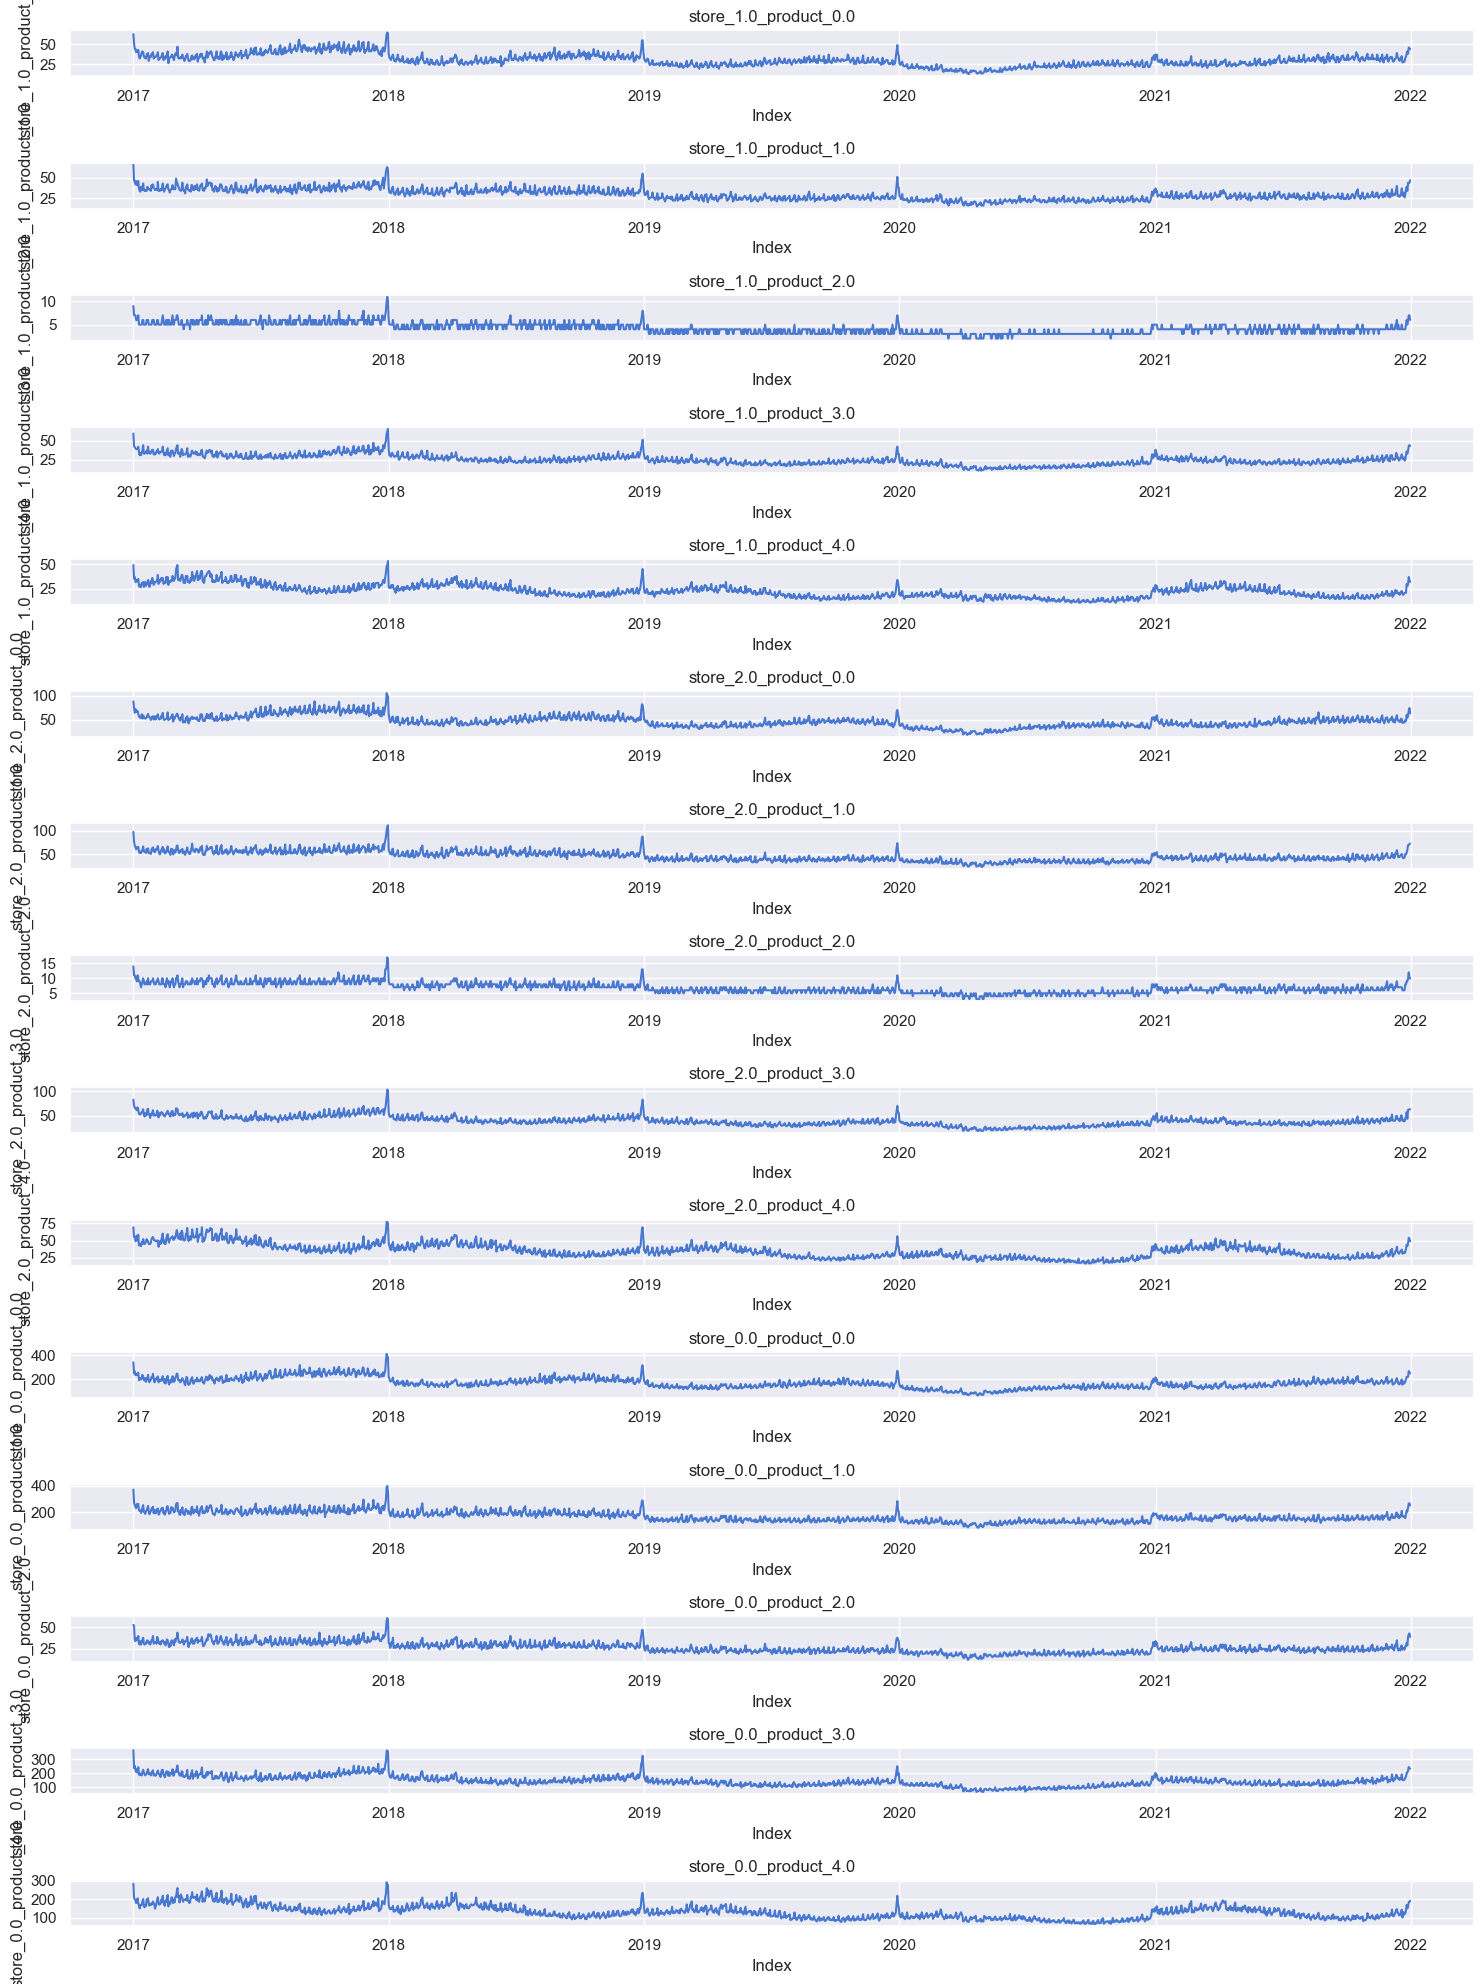

In [44]:
fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 20))

# Iterate over columns and create line charts
for i, (col, ax) in enumerate(zip(df.columns, axes.flat)):
  sns.lineplot(x=df.index, y=df[col], ax=ax)
  ax.set_title(col)
  ax.set_xlabel('Index')
  ax.set_ylabel(col)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [45]:
row_sums = df.sum(axis=1)
df['Total'] = row_sums
df.head()


,store_1.0_product_0.0,store_1.0_product_1.0,store_1.0_product_2.0,store_1.0_product_3.0,store_1.0_product_4.0,store_2.0_product_0.0,store_2.0_product_1.0,store_2.0_product_2.0,store_2.0_product_3.0,store_2.0_product_4.0,store_0.0_product_0.0,store_0.0_product_1.0,store_0.0_product_2.0,store_0.0_product_3.0,store_0.0_product_4.0,Total
2017-01-01,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,2011
2017-01-02,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,1487
2017-01-03,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,1448
2017-01-04,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,1357
2017-01-05,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,1316


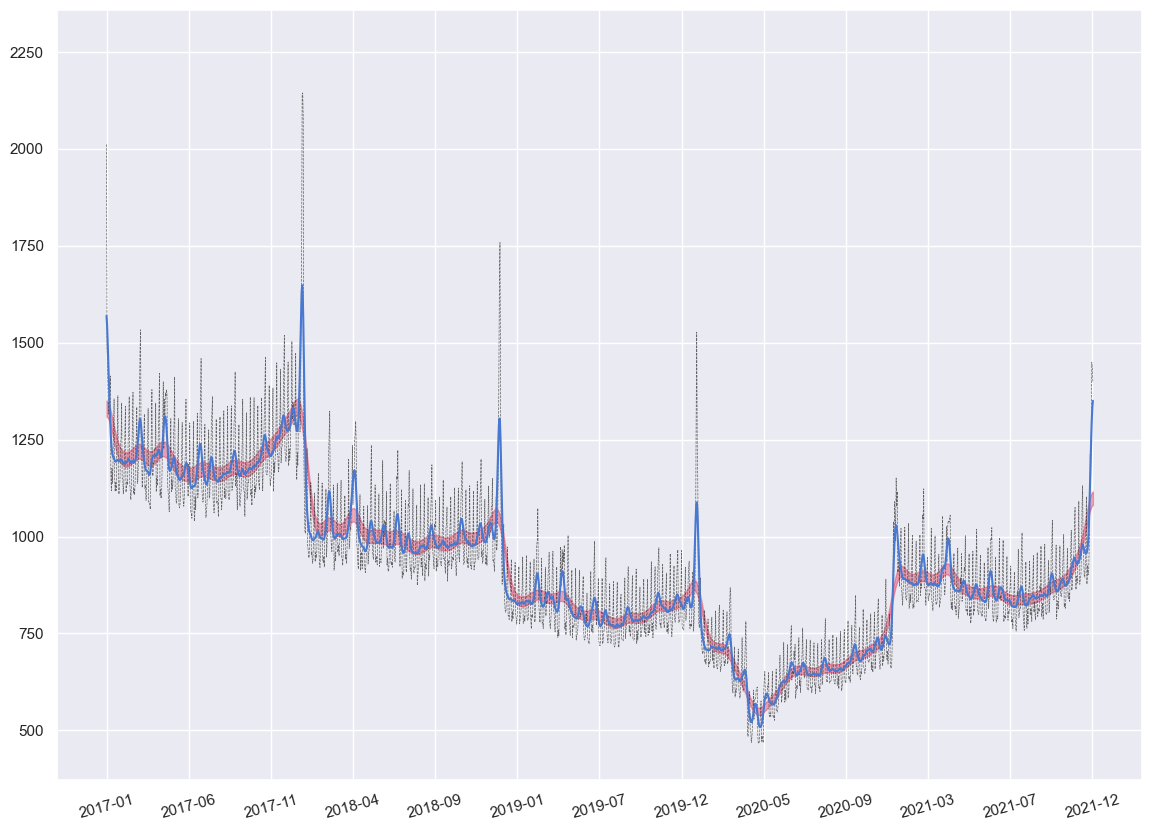

In [46]:
# Calculate the row-wise sum without assigning to a named Series
sns.set(style="darkgrid", palette="muted", color_codes=True)  # Use color_dates for automatic color mapping
fig, ax = plt.subplots(figsize=(14, 10))
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
total_column = df['Total']

# Align data and date range (if necessary)
if len(df) != len(date_range):
    df = df.reindex(date_range, fill_value=np.nan)  # Reindex to match date range

# Select data based on reindexed DataFrame (if necessary)
total_column = df['Total']

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=3)

# Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [47]:
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier, Seasonality
from statsmodels.tsa.api import SARIMAX

four = Fourier(period=182.5, order=3)
seas = Seasonality(period=7)
# Assuming 'train' is your DataFrame with 'num_sold_scaled' as the target variable
det_proc = DeterministicProcess(df.index, additional_terms=[ seas, four])
#det_proc.in_sample()


### SARIMAX

C:\Users\domin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


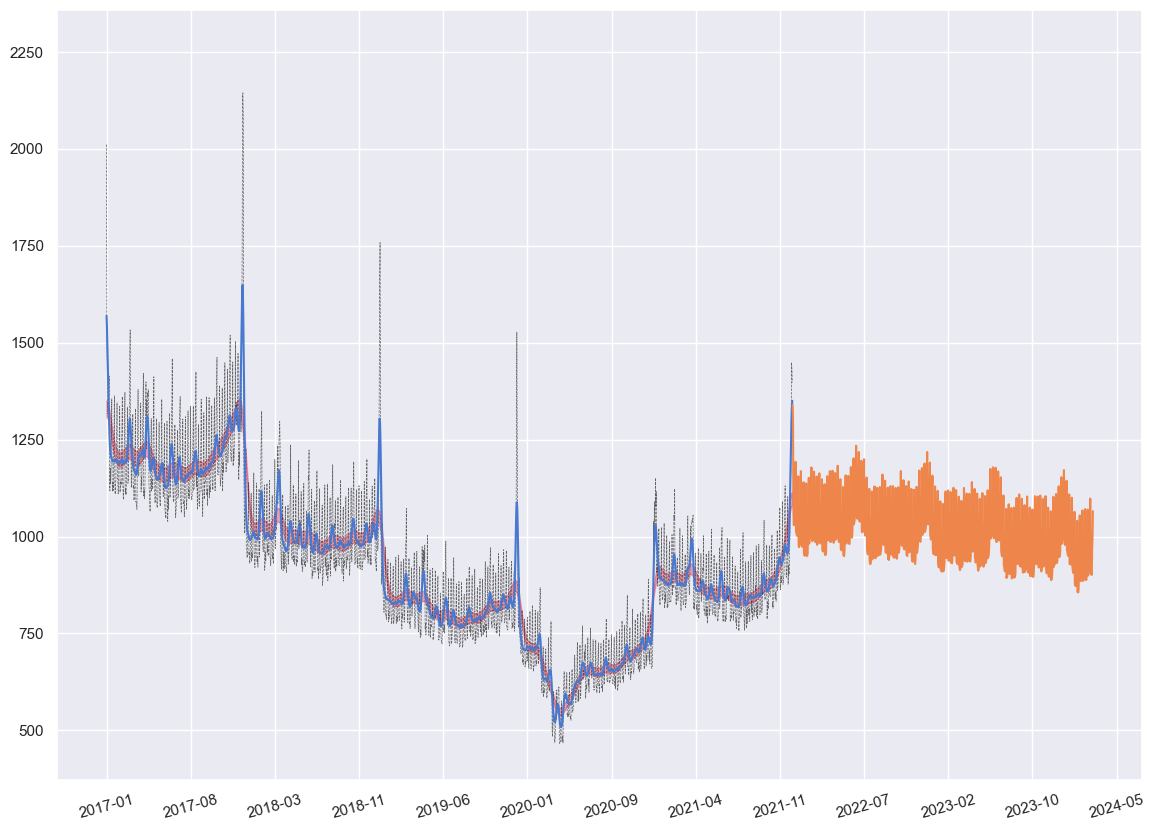

In [48]:
model = SARIMAX(df['Total'],
                     order=(4, 0, 8),  # Adjust order parameters as needed
                     seasonal_order=(2, 1, 2, 24),  # Adjust seasonal order as needed
                     exog=det_proc.in_sample())
#
SARIMAX_fit = model.fit()
#print(SARIMAX_fit.summary())
forecast_results = SARIMAX_fit.forecast(steps=800, exog=det_proc.out_of_sample(800))  # Forecast for 12 steps (e.g., 12 months)
forecast_df = pd.DataFrame(forecast_results)



fig, ax = plt.subplots(figsize=(14, 10))
# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex
ax.plot(forecast_df.index, forecast_df['predicted_mean'], label='Forecast')
# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import statsmodels.api as sm
import warnings
from numba import jit


# # Define the p, d, q parameters to take any value between
# p = d = q = range(0, 4)

# # Generate all different combinations of p, d and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, d, q and quadruplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# temp_model = None



# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             temp_model = sm.tsa.statespace.SARIMAX(df['Total'],
#                                                   order=param,
#                                                   seasonal_order=param_seasonal,
#                                                   enforce_stationarity=False,
#                                                   enforce_invertibility=False,
#                                                   exog=det_proc.in_sample())
#             results = temp_model.fit()
#             print(f"SARIMA{param}{param_seasonal} - AIC: {results.aic}")
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = param_seasonal
#         except:
#             continue

# print(f"Best SARIMA model - AIC: {best_pdq}, {best_seasonal_pdq}, {best_aic}")

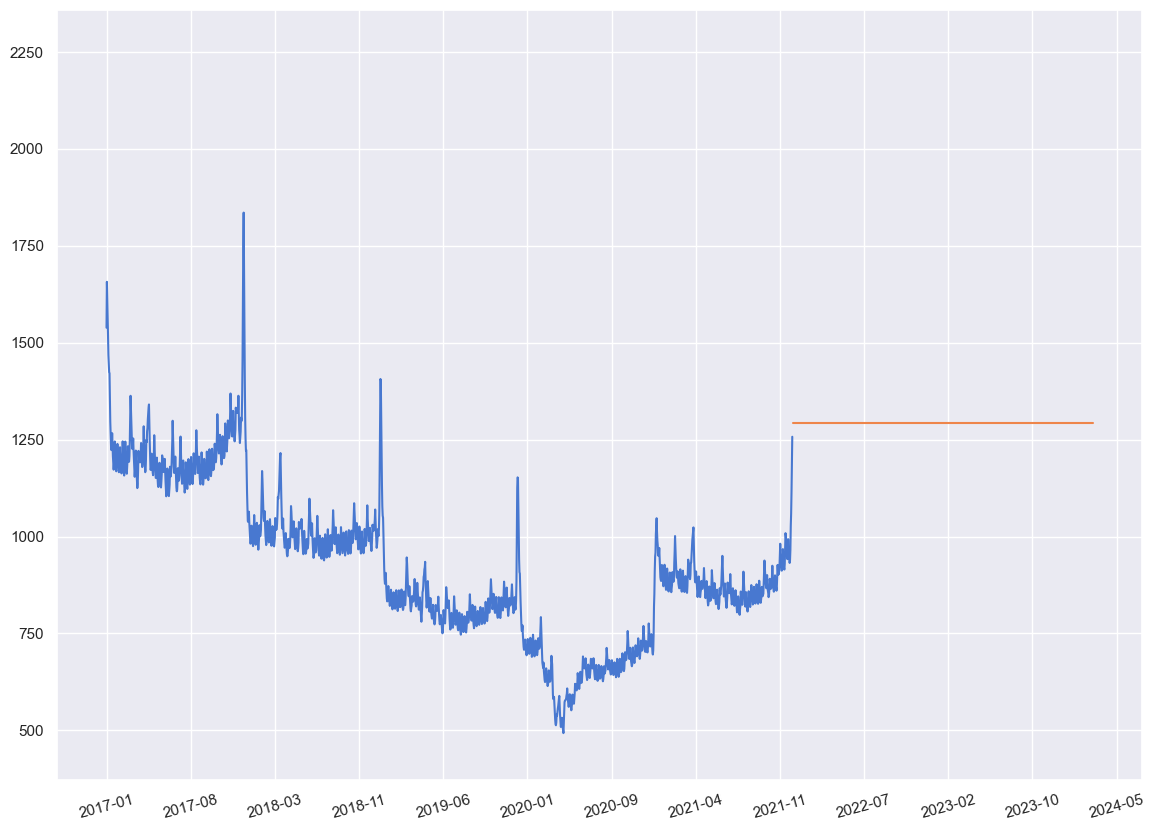

In [62]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model=[]

model = ExponentialSmoothing(df['Total'])

# Set smoothing parameters (adjust alpha, beta, gamma as needed)
alpha = 0.25  # Smoothing level parameter (0 < alpha <= 1)
beta = 0.5  # Trend smoothing parameter (0 for no trend, 0 < beta < 1 for trend)
gamma = 0.5  # Seasonal smoothing parameter (0 < gamma <= 1)

# Fit the model with the specified smoothing parameters
fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

level = fitted_model.fittedvalues
fited_df = pd.DataFrame(level)
forecasts = fitted_model.forecast(800)
forecast_df = pd.DataFrame(forecasts)

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(fited_df.index, fited_df[:], label='Fit')
ax.plot(forecast_df.index, forecast_df[:], label='Forecast')

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

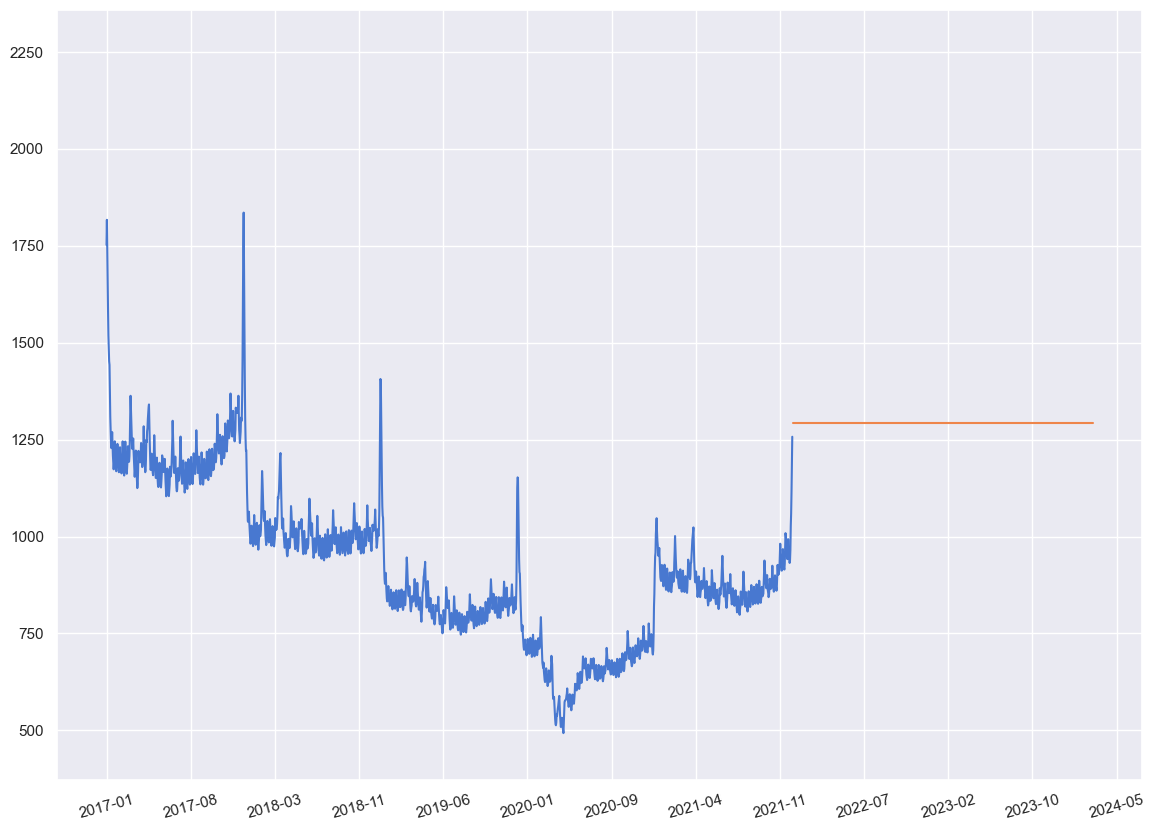

In [51]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(df['Total'], initialization_method="estimated")

# Set smoothing parameters (adjust alpha, beta, gamma as needed)
alpha = 0.25  # Smoothing level parameter (0 < alpha <= 1)
# beta = 0.75  # Trend smoothing parameter (0 for no trend, 0 < beta < 1 for trend)
# gamma = 0.5  # Seasonal smoothing parameter (0 < gamma <= 1)

# Fit the model with the specified smoothing parameters
fitted_model = model.fit(smoothing_level=alpha, optimized=False)

level = fitted_model.fittedvalues
fited_df = pd.DataFrame(level)
forecasts = fitted_model.forecast(800)
forecast_df = pd.DataFrame(forecasts)


fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(fited_df.index, fited_df[:], label='Fit')
ax.plot(forecast_df.index, forecast_df[:], label='Forecast')

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

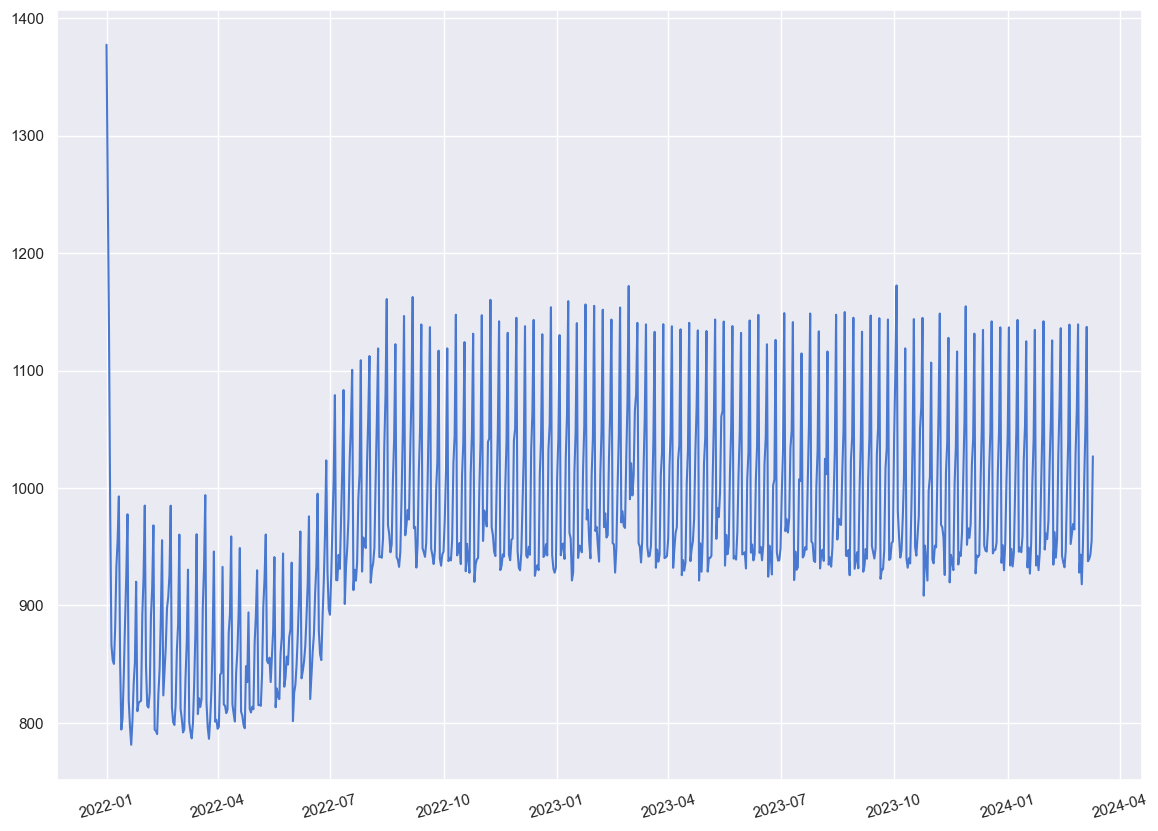

In [52]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
                 regressor       = XGBRegressor(random_state=123),
                 lags            = 24,
                 differentiation = None
             )

forecaster.fit(y=df['Total'])
forecast_df=forecaster.predict(steps=800)

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(forecast_df.index, forecast_df[:], label='Forecast')

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [53]:
df['Total'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Freq: D
Series name: Total
Non-Null Count  Dtype
--------------  -----
1826 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


In [54]:
df.Total

2017-01-01    2011
2017-01-02    1487
2017-01-03    1448
2017-01-04    1357
2017-01-05    1316
              ... 
2021-12-27    1158
2021-12-28    1280
2021-12-29    1449
2021-12-30    1434
2021-12-31    1397
Freq: D, Name: Total, Length: 1826, dtype: int64

In [74]:
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import warnings

model = create_and_compile_model(
    series=pd.DataFrame(df["Total"]),
    levels=[df["Total"]], 
    lags=48,
    steps=800,
    recurrent_layer="LSTM",
    recurrent_units=[256, 128],
    dense_units=[768, 384],
    optimizer=Adam(learning_rate=0.0125), 
    loss=MeanSquaredError()
)
model.summary()

forecaster = ForecasterRnn(
    regressor=model,
    levels=[df["Total"].name],
    fit_kwargs={
        "epochs": 300,  # Number of epochs to train the model.
        "batch_size": 48,  # Batch size to train the model.     
    },
)    

forecaster.fit(pd.DataFrame(df["Total"]))
predictions = forecaster.predict(800)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 1)]           0         
                                                                 
 lstm_17 (LSTM)              (None, 48, 256)           264192    
                                                                 
 lstm_18 (LSTM)              (None, 128)               197120    
                                                                 
 dense_28 (Dense)            (None, 768)               99072     
                                                                 
 dense_29 (Dense)            (None, 384)               295296    
                                                                 
 dense_30 (Dense)            (None, 800)               308000    
                                                                 
 reshape_11 (Reshape)        (None, 800, 1)            0  

C:\Users\domin\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:227: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
C:\Users\domin\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:257: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


21/21 [==============================] - 2s 42ms/step - loss: 2.9845
Epoch 2/300
21/21 [==============================] - 1s 44ms/step - loss: 0.0131
Epoch 3/300
21/21 [==============================] - 1s 44ms/step - loss: 0.0102
Epoch 4/300
21/21 [==============================] - 1s 45ms/step - loss: 69.1687
Epoch 5/300
21/21 [==============================] - 1s 47ms/step - loss: 0.0146
Epoch 6/300
21/21 [==============================] - 1s 46ms/step - loss: 0.0099
Epoch 7/300
21/21 [==============================] - 1s 48ms/step - loss: 5.9575
Epoch 8/300
21/21 [==============================] - 1s 48ms/step - loss: 0.0238
Epoch 9/300
21/21 [==============================] - 1s 48ms/step - loss: 0.0093
Epoch 10/300
21/21 [==============================] - 1s 48ms/step - loss: 0.0078
Epoch 11/300
21/21 [==============================] - 1s 48ms/step - loss: 0.0077
Epoch 12/300
21/21 [==============================] - 1s 48ms/step - loss: 0.0073
Epoch 13/300
21/21 [================

C:\Users\domin\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:719: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29976162 0.22348033 0.22288439 0.23241955 0.21871275 0.26698451
 0.29856973 0.32777116 0.23539928 0.24374255 0.26340882 0.27353993
 0.30035757 0.33551847 0.36293206 0.24076281 0.23659118 0.25744934
 0.24672229 0.27830751 0.29082241 0.37246722 0.24493445 0.24493445
 0.25506555 0.25923719 0.30333731 0.36710369 0.39630513 0.3045292
 0.28486293 0.2568534  0.2556615  0.27413588 0.31883194 0.37961859
 0.24493445 0.27413588 0.26102503 0.25983313 0.29380215 0.34564958
 0.44457688 0.41239571 0.48510131 0.58581645 0.57687723 0.55482718]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
tensorflow WARNING 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at

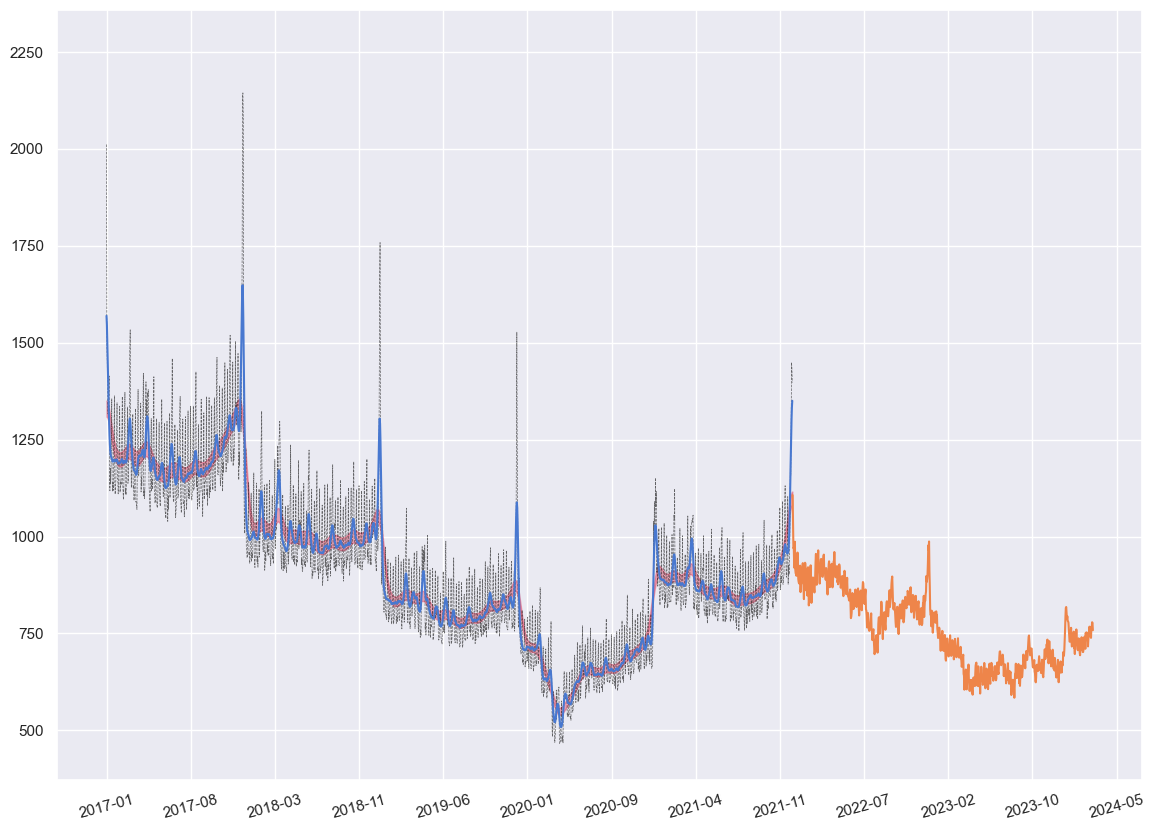

In [75]:
fig, ax = plt.subplots(figsize=(14, 10))
# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex
ax.plot(predictions.index, predictions, label='Forecast')
# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

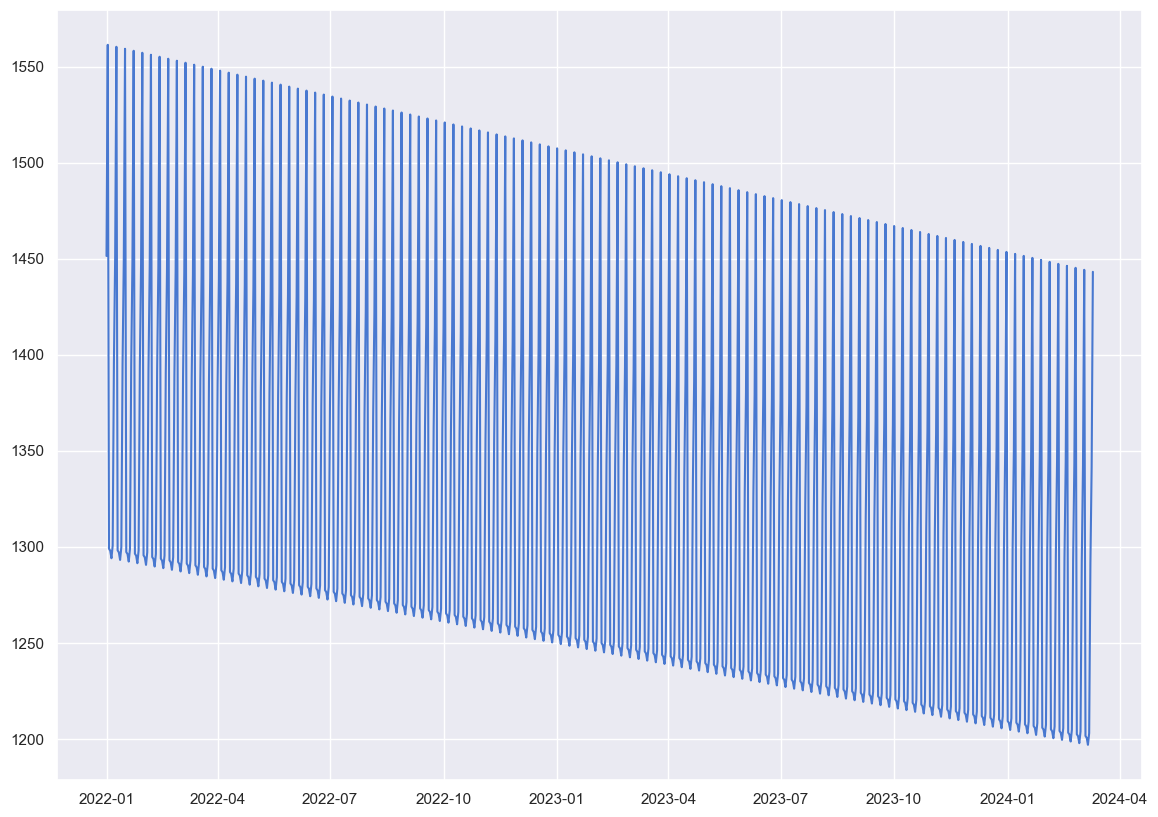

In [57]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(df['Total'])
res = tm.fit()
#print(res.summary())
forecast_df=res.forecast(800)

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(forecast_df.index, forecast_df[:], label='Forecast')